<a href="https://colab.research.google.com/github/SanjaySaatyaki/fast_ai_try_out/blob/main/tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1
import fastbook
fastbook.setup_book()

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.2 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8


In [3]:
!pip install kaggle

In [4]:
creds = '{"username":"sanjaysaatyaki","key":"0532e575ab910ac7a5214493e35e81ae"}'

In [5]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 83.6MB/s]

In [7]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [8]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",...,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",...,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",...,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",...,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",...,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",...,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",...,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",...,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",...,111369,30.0000,C148,C


In [9]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
df.head()

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",...,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",...,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",...,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",...,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",...,373450,8.0500,NaN,S


In [11]:
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [12]:
df.fillna(df.mode().iloc[0],inplace=True)

In [13]:
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


<Axes: >

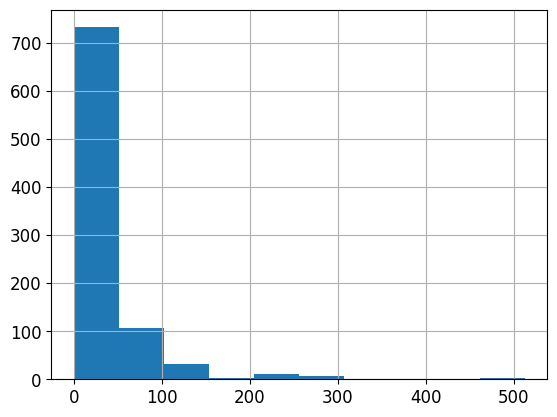

In [14]:
df.Fare.hist()

In [15]:
df['logFare'] = np.log(df['Fare']+1)

<Axes: >

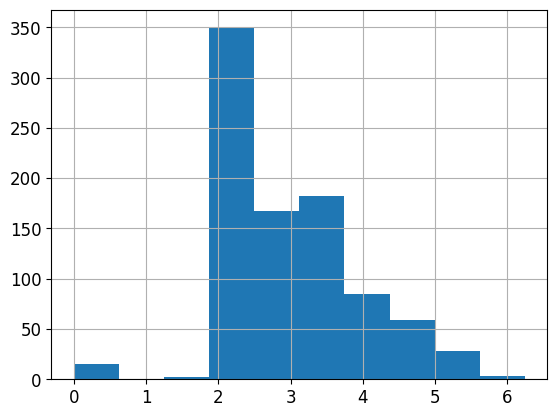

In [16]:
df.logFare.hist()

In [17]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,1601,B96 B98,S
freq,1,577,7,691,646


<Axes: >

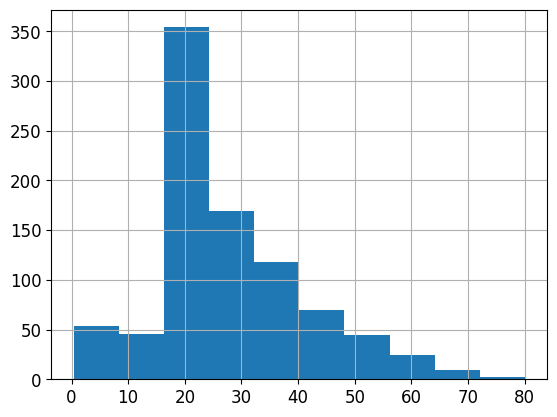

In [18]:
df.Age.hist()

In [19]:
df['Age'] = df['Age']/df['Age'].max()

<Axes: >

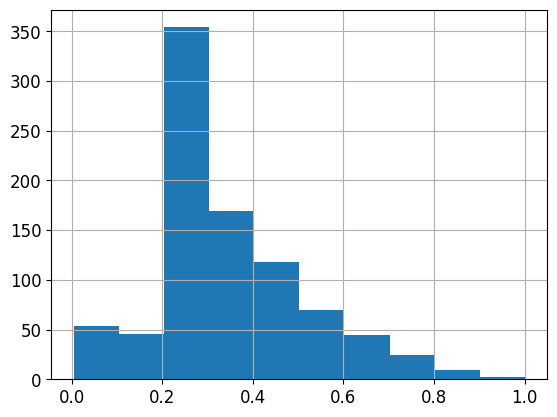

In [20]:
df.Age.hist()

In [21]:
df = pd.get_dummies(df,columns=['Sex','Pclass','Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'logFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [22]:
from torch import tensor

t_dep = tensor(df.Survived)

In [23]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

In [24]:
for col in df.columns:
  if df[col].dtype == bool:
    df[col] = df[col].astype('int64')
    print(f"{col}: {df[col].dtype}")

Sex_female: int64
Sex_male: int64
Pclass_1: int64
Pclass_2: int64
Pclass_3: int64
Embarked_C: int64
Embarked_Q: int64
Embarked_S: int64


In [25]:
indep_cols = ['Age', 'SibSp', 'Parch', 'logFare'] + added_cols

# Exclude 'Name', 'Ticket', and 'Cabin' columns, and boolean columns
indep_cols_numeric = [col for col in indep_cols if col in df.columns and df[col].dtype != object]

t_indep = tensor(df[indep_cols_numeric].values, dtype=torch.float)
t_indep

tensor([[0.2750, 1.0000, 0.0000, 2.1102, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 1.0000, 0.0000, 4.2806, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 2.1889, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 1.0000, 0.0000, 3.9908, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.0000, 2.2028, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 2.2469, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.0000, 3.9677, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.0000, 2.0857, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 5.0000, 3.4054, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 

In [26]:
from torch import nn

In [43]:
linear_model = nn.Sequential(
    nn.Linear(in_features=12, out_features=20),
    nn.Linear(in_features=20, out_features=1),
    nn.ReLU()
)

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train,X_test,Y_train, Y_test = train_test_split(t_indep,t_dep, test_size=0.2)


In [46]:
X_train.dtype, X_test.dtype, Y_train.dtype, Y_test.dtype

(torch.float32, torch.float32, torch.int64, torch.int64)

In [47]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=linear_model.parameters(),lr= 0.03)

In [49]:
epochs = 1000

for epoch in range(epochs):
  linear_model.train()
  y_logits = linear_model(X_train).squeeze()

  loss = loss_fn(y_logits, Y_train.float())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  linear_model.eval()
  with torch.inference_mode():
    test_logits = linear_model(X_test).squeeze()

    test_loss = loss_fn(test_logits,Y_test.float())
  if epoch % 100 ==0:
    print(f"Epoch : {epoch} | Loss: {loss:.4f}| Test Loss: {test_loss:.4f}")

Epoch : 0 | Loss: 0.7153| Test Loss: 0.7209
Epoch : 100 | Loss: 0.6501| Test Loss: 0.6547
Epoch : 200 | Loss: 0.6377| Test Loss: 0.6446
Epoch : 300 | Loss: 0.6288| Test Loss: 0.6378
Epoch : 400 | Loss: 0.6215| Test Loss: 0.6322
Epoch : 500 | Loss: 0.6152| Test Loss: 0.6272
Epoch : 600 | Loss: 0.6102| Test Loss: 0.6237
Epoch : 700 | Loss: 0.6060| Test Loss: 0.6208
Epoch : 800 | Loss: 0.6027| Test Loss: 0.6189
Epoch : 900 | Loss: 0.6000| Test Loss: 0.6176


In [34]:
df = pd.read_csv(path/'train.csv')

In [35]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

In [36]:
splits = RandomSplitter(seed=42)(df)

In [37]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

/usr/local/lib/python3.12/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [38]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.12022644281387329, valley=0.004365158267319202)

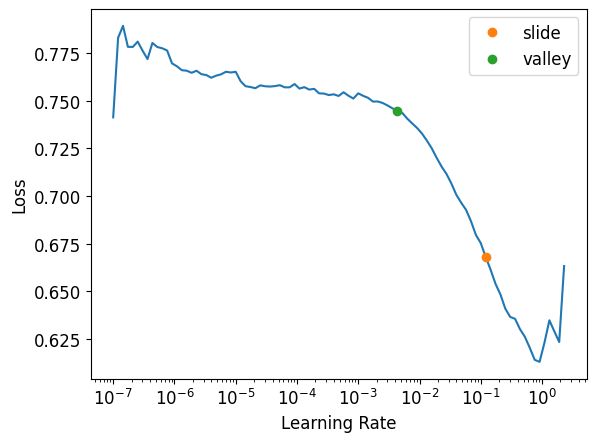

In [39]:
learn.lr_find(suggest_funcs=(slide, valley))

In [40]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.574159,0.583236,0.696629,00:00
1,0.468275,0.593488,0.758427,00:00
2,0.470044,0.443230,0.792135,00:00
3,0.449453,0.468195,0.831461,00:00
4,0.433726,0.425843,0.820225,00:00
5,0.421721,0.442128,0.831461,00:00
6,0.413196,0.403434,0.814607,00:00
7,0.404575,0.403717,0.825843,00:00
8,0.396223,0.426416,0.814607,00:00
9,0.391517,0.429294,0.820225,00:00


In [50]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [52]:
tst_dl = learn.dls.test_dl(tst_df)

/usr/local/lib/python3.12/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [53]:
preds,_ = learn.get_preds(dl=tst_dl)

In [54]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [55]:
!head sub.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1
